In [1]:
import csv
import pandas as pd
import re
import string
import numpy as np
import math
from random import sample
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
from random import choices
import statsmodels.api as sm
import pylab as py
from scipy.stats import norm
from scipy.stats import expon
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [2]:
#Each domain has a label with at most 63 characters that consists only of English letters, digits, or hyphens
def clean_data(domains, labels):
    
    index = 0
    for domain in domains:
        if len(domain) > 63 or not re.match("^[A-Za-z0-9._-]*$", domain):
            domains.remove(domain)
            labels.remove(labels[index])
            index -= 1
        index += 1
        
    return domains, labels


In [2]:
#read in original test and training data

with open('test1.txt') as f:
    lines = f.readlines()
    test1 = [line.rstrip() for line in lines]
    
with open('test2.txt') as f:
    lines = f.readlines()
    test2 = [line.rstrip() for line in lines]
    
with open('test1label.txt') as f:
    lines = f.readlines()
    test1label = [line.rstrip() for line in lines]
    
with open('test2label.txt') as f:
    lines = f.readlines()
    test2label = [line.rstrip() for line in lines]
    
with open('training.csv', 'r') as file:
    reader = csv.reader(file)
    train = []
    trainlabel = []
    for row in reader:
        train.append(row[0])
        trainlabel.append(row[1])
        
#clean data
#test1, test1label = clean_data(test1, test1label)
#test2, test2label = clean_data(test2, test2label)
#train, trainlabel = clean_data(train, trainlabel)

In [4]:
#Sort original training data into benign and malicious
newtrainAGD = []
newtrainbenign = []
for i in range(len(trainlabel)):
    if trainlabel[i] == '1':
        newtrainAGD.append(train[i])
    else:
        newtrainbenign.append(train[i])
newAGDlabel = ['1']*len(newtrainAGD)
newbenignlabel = ['0']*len(newtrainbenign)

#Sort original testing data into benign and malicious
newtestAGD = []
newtestbenign = []
for i in range(len(test1label)):
    if test1label[i] == '1':
        newtestAGD.append(test1[i])
    else:
        newtestbenign.append(test1[i])

for i in range(len(test2label)):
    if test2label[i] == '1':
        newtestAGD.append(test2[i])
    else:
        newtestbenign.append(test2[i])
        
newtestAGDlabel = ['1']*len(newtestAGD)
newtestbenignlabel = ['0']*len(newtestbenign)


In [5]:
#Read in MaskDGA adversarial training and test datasets
with open('advTrain_sub-cnn_prec-50.csv', 'r') as file:
    reader = csv.reader(file)
    advTrain = []
    for row in reader:
        advTrain.append(row[2])
    advTrain.remove('url')
    
with open('test_sub-cnn_prec-25.csv', 'r') as file:
    reader = csv.reader(file)
    advTest25 = []
    for row in reader:
        advTest25.append(row[2])
    advTest25.remove('url')
    
with open('test_sub-cnn_prec-50.csv', 'r') as file:
    reader = csv.reader(file)
    advTest50 = []
    for row in reader:
        advTest50.append(row[2])
    advTest50.remove('url')
    
with open('test_sub-cnn_prec-75.csv', 'r') as file:
    reader = csv.reader(file)
    advTest75 = []
    for row in reader:
        advTest75.append(row[2])
    advTest75.remove('url')
    
with open('test_sub-lstm_prec-50.csv', 'r') as file:
    reader = csv.reader(file)
    advTestlstm50 = []
    for row in reader:
        advTestlstm50.append(row[2])
    advTestlstm50.remove('url')
        
with open('test_sub-lstm_prec-75.csv', 'r') as file:
    reader = csv.reader(file)
    advTestlstm75 = []
    for row in reader:
        advTestlstm75.append(row[2])
    advTestlstm75.remove('url')
    
advTrainlabel = ['2']*len(advTrain)
advTestlabel25 = ['2']*len(advTest25)
advTestlabel50 = ['2']*len(advTest50)
advTestlabel75 = ['2']*len(advTest75)
advTest2label50 = ['2']*len(advTestlstm50)
advTest2label75 = ['2']*len(advTestlstm75)


In [15]:
#Extract features from domain names
#length of domain name, percentage of numerical characters, percentage of vowels, percentage of symbols,
#flag to see if first character is a digit, flag to see if name contains alphanumeric characters
#consecutive consonant's percentage

def extract(domains):
    
    #features
    length = []
    num_perc = []
    vowel_perc = []
    symbol_perc = []
    first_digit = []
    mixture = []
    consec = []
    
    for name in domains:
        
        name_length = len(name)
        length.append(name_length)
        #length.append(0)         #toggles off length being a feature
        
        numer = 0
        vowel = 0
        symbol = 0
        counter = 0
        has_letter = False
        has_number = False
        last_cons = False
        for ch in name:
            if ch.isdigit():
                numer += 1
                has_number = True
            elif ch in ['a','e','i','o','u']:
                vowel += 1
            elif ch in ['.','-','_']:
                symbol += 1
                
            if ch.isalpha():
                has_letter = True
                
            if ch not in ['a','e','i','o','u']:
                if last_cons == True:
                    counter += 1
                last_cons = True
            else:
                last_cons = False
                
        if has_letter and has_number:
            mixture.append(1)
            #mixture.append(0)
        else:
            mixture.append(0)
        
        vowel_perc.append(vowel/name_length)
        num_perc.append(numer/name_length)
        symbol_perc.append(symbol/name_length)
        consec.append(counter/(name_length))
        #consec.append(0)
        
        if name[0].isdigit():
            first_digit.append(1)
        else:
            first_digit.append(0)

    features = [length, num_perc, vowel_perc, symbol_perc, first_digit, mixture, consec]
    
    return features
       

In [10]:
#Converts to form suitable to input to python function
def convert(features):
    
    length = features[0]
    num_perc = features[1]
    vowel_perc = features[2]
    symbol_perc = features[3]
    first_digit = features[4]
    mixture = features[5]
    consec = features[6]
    num_domains = len(length)
    
    X = [0]*num_domains
    for i in range(num_domains):
        X[i] = [length[i], num_perc[i], vowel_perc[i], symbol_perc[i], first_digit[i], mixture[i], consec[i]]
        
    return X

In [20]:
split=split1=split2= 20000

#Average features for the 3 types of domains
examine_adv = extract(advTrain[0:split])
examine_benign = extract(newtrainbenign[0:split1])
examine_AGD = extract(newtrainAGD[0:split2])

#Length
print("LENGTH")
print(np.mean(examine_adv[0]), np.var(examine_adv[0]))
print(np.mean(examine_benign[0]), np.var(examine_benign[0]))
print(np.mean(examine_AGD[0]), np.var(examine_AGD[0]))

#Digit ratio
print("\nDigit Ratio")
print(np.mean(examine_adv[1]), np.var(examine_adv[1]))
print(np.mean(examine_benign[1]), np.var(examine_benign[1]))
print(np.mean(examine_AGD[1]), np.var(examine_AGD[1]))

#Vowel ratio
print("\nVowel Ratio")
print(np.mean(examine_adv[2]), np.var(examine_adv[2]))
print(np.mean(examine_benign[2]), np.var(examine_benign[2]))
print(np.mean(examine_AGD[2]), np.var(examine_AGD[2]))

#Symbol ratio
print("\nSymbol Ratio")
print(np.mean(examine_adv[3]), np.var(examine_adv[3]))
print(np.mean(examine_benign[3]), np.var(examine_benign[3]))
print(np.mean(examine_AGD[3]), np.var(examine_AGD[3]))

#Flag for first digit
print("\nFirst Digit")
print(np.mean(examine_adv[4]))
print(np.mean(examine_benign[4]))
print(np.mean(examine_AGD[4]))

#Flag for mixture
print("\nMixture")
print(np.mean(examine_adv[5]))
print(np.mean(examine_benign[5]))
print(np.mean(examine_AGD[5]))

#Consecutive consonant ratio
print("\nConsecutive Consonant Ratio")
print(np.mean(examine_adv[6]), np.var(examine_adv[6]))
print(np.mean(examine_benign[6]), np.var(examine_benign[6]))
print(np.mean(examine_AGD[6]), np.var(examine_AGD[6]))


LENGTH
19.65985 31.593447977500002
20.01845 92.6765095975
18.3677 27.929596710000002

Digit Ratio
0.08974216774789974 0.004785906301977327
0.06130014052073128 0.014742542171233174
0.0386491575417889 0.00834889301160797

Vowel Ratio
0.139281019920553 0.005825216026980587
0.28182910238611303 0.008832998800385123
0.22950398324590338 0.01042582612647727

Symbol Ratio
0.4044235836648258 0.033583090563567605
0.11617701975262994 0.002053137784955739
0.06412068049832784 0.00038532745179191863

First Digit
0.2189
0.0741
0.0565

Mixture
0.82735
0.33225
0.18065

Consecutive Consonant Ratio
0.6954363273098833 0.01785121152842887
0.42517149290547057 0.026432833480784568
0.5311123567361397 0.03084148068292384


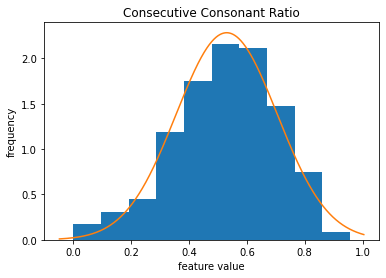

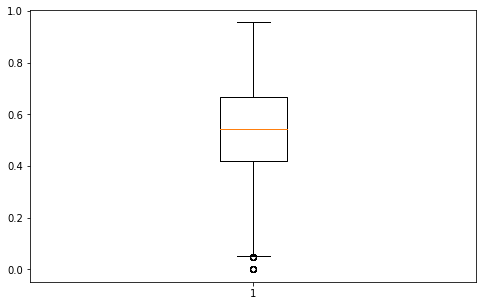

In [34]:
#check the distribution of each continuous feature given class (index 1,2,3,6)
#digit ratio, vowel ratio, symbol ratio, consecutive consonant ratio
  
# Random data points generated
#data_points = np.array(examine_adv[6])
#data_points = np.array(examine_benign[6])
data_points = np.array(examine_AGD[6])

#plot normal distribution
norm_points = np.random.normal(np.mean(data_points), np.sqrt(np.var(data_points)), 20000)  
mu, std = norm.fit(norm_points)
plt.hist(data_points, bins = 10, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.title('Digit Ratio')
plt.title('Vowel Ratio')
plt.title('Symbol Ratio')
plt.title('Consecutive Consonant Ratio')
plt.xlabel('feature value')
plt.ylabel('frequency')
plt.plot(x,p)
plt.show()
fig = plt.figure(figsize =(8, 5))
plt.boxplot(data_points)
plt.show()


In [10]:
#common function used by filter_density and filter_relative_density
#computes the average density of a point
def average_density(j, length, sorted_list, k):
    
    #Takes the 2 values above and two values below in the sorted list, and sum their distances from the current feature
    if j >= k and j < length-k:
        n1 = j-2
        n2 = j-1
        n3 = j+1
        n4 = j+2
        value = abs((sorted_list[n1]+sorted_list[n2]+sorted_list[n3]+sorted_list[n4] 
                                  - 2*k*sorted_list[j]) / (2*k))
    elif j == 0:
        n1 = 1
        n2 = 2
        n3 = 3
        n4 = 4
        value = abs((sorted_list[n1]+sorted_list[n2]+sorted_list[n3]+sorted_list[n4] 
                                  - 2*k*sorted_list[0]) / (2*k))
    elif j == 1:
        n1 = 0
        n2 = 2
        n3 = 3
        n4 = 4
        value = abs((sorted_list[n1]+sorted_list[n2]+sorted_list[n3]+sorted_list[n4] 
                                  - 2*k*sorted_list[1]) / (2*k))
    elif j == length-1:
        n1 = length-2
        n2 = length-3
        n3 = length-4
        n4 = length-5
        value = abs((sorted_list[n1]+sorted_list[n2]+sorted_list[n3]+sorted_list[n4] 
                                  - 2*k*sorted_list[length-1]) / (2*k))
    else:
        n1 = length-1
        n2 = length-3
        n3 = length-4
        n4 = length-5
        value = abs((sorted_list[n1]+sorted_list[n2]+sorted_list[n3]+sorted_list[n4] 
                                  - 2*k*sorted_list[length-2]) / (2*k))
        
    if value == 0.0:
        return 1/0.0000001, [n1, n2, n3, n4]
    else:
        return 1/value, [n1, n2, n3, n4]
    


In [11]:
#applies density-based anomaly detection to a specific feature - filters all data points out
#that have an average density of less than a specified threshold
def filter_density(data, examined, value, threshold):
    
    feature = data[examined]
    length = len(feature)
    
    new_feature0 = []
    new_feature1 = []
    new_feature2 = []
    new_feature3 = []
    new_feature4 = []
    new_feature5 = []
    new_feature6 = []
    
    remember = np.argsort(feature).tolist()
    sorted_list = sorted(feature)
    k = 2
    
    variance = np.var(feature)
        
    for i in range(length):
        j = remember.index(i)

        avg_density, _ = average_density(j, length, sorted_list, k)

        if 1/avg_density < threshold*variance:
            new_feature0.append(data[0][i])
            new_feature1.append(data[1][i])
            new_feature2.append(data[2][i])
            new_feature3.append(data[3][i])
            new_feature4.append(data[4][i])
            new_feature5.append(data[5][i])
            new_feature6.append(data[6][i])

    new_features = [new_feature0, new_feature1, new_feature2, new_feature3, new_feature4, new_feature5, new_feature6]
    new_labels = [value]*len(new_feature0)
    
    return new_features, new_labels


In [12]:
#applies density-based anomaly detection to a specific feature - filters all data points out
#based on the relative density of itself to its neighbours
def filter_relative_density(data, examined, value, threshold):
    
    feature = data[examined]
    length = len(feature)
    
    new_feature0 = []
    new_feature1 = []
    new_feature2 = []
    new_feature3 = []
    new_feature4 = []
    new_feature5 = []
    new_feature6 = []
    
    remember = np.argsort(feature).tolist()
    sorted_list = sorted(feature)
    k = 2
        
    for i in range(length):
        j = remember.index(i)

        #Takes the 2 values above and two values below in the sorted list, and sum their distances from the current feature
        avg_density, neighbours = average_density(j, length, sorted_list, k)
        
        #relative to the density of those neighbours
        sum_neigh_dens = 0
        for each in neighbours:
            dens, _ = average_density(each, length, sorted_list, k)
            sum_neigh_dens += dens
        sum_neigh_dens /= 4
        relative_density = avg_density / sum_neigh_dens

        #LOF
        if relative_density == 0.0:
            lof = 1/0.0000001
        else:
            lof = 1/relative_density
          
        if lof <= 1*threshold:
            new_feature0.append(data[0][i])
            new_feature1.append(data[1][i])
            new_feature2.append(data[2][i])
            new_feature3.append(data[3][i])
            new_feature4.append(data[4][i])
            new_feature5.append(data[5][i])
            new_feature6.append(data[6][i])

    new_features = [new_feature0, new_feature1, new_feature2, new_feature3, new_feature4, new_feature5, new_feature6]
    new_labels = [value]*len(new_feature0)
    
    return new_features, new_labels



In [13]:
#applies statistical-based anomaly detection to a specific feature - filters all data points out
#based on the interquartile range
def filter_feature_IQR(data, examined, value, threshold):
    
    feature = data[examined]
    
    Q1 = np.percentile(feature, 25)
    Q3 = np.percentile(feature, 75)
    IQR = Q3 - Q1
    
    new_feature0 = []
    new_feature1 = []
    new_feature2 = []
    new_feature3 = []
    new_feature4 = []
    new_feature5 = []
    new_feature6 = []

    for i in range(len(feature)):
        if feature[i] <= Q3 + 1.5*IQR and feature[i] >= Q1 - 1.5*IQR:
            new_feature0.append(data[0][i])
            new_feature1.append(data[1][i])
            new_feature2.append(data[2][i])
            new_feature3.append(data[3][i])
            new_feature4.append(data[4][i])
            new_feature5.append(data[5][i])
            new_feature6.append(data[6][i])
    
    new_features = [new_feature0, new_feature1, new_feature2, new_feature3, new_feature4, new_feature5, new_feature6]
    
    return new_features, [value]*len(new_feature0)


In [14]:
#applies statistical-based anomaly detection to a specific feature - filters all data points out
#based on the 3 sigma rule
def filter_features(data, examined, value, threshold):
    
    feature = data[examined]
    
    mu = np.mean(feature)
    variance = np.var(feature)
    sigma = math.sqrt(variance)
    #sigma = np.inf #toggles off filtering
    
    new_feature0 = []
    new_feature1 = []
    new_feature2 = []
    new_feature3 = []
    new_feature4 = []
    new_feature5 = []
    new_feature6 = []
    
    for i in range(len(feature)):
        if feature[i] <= mu+3*sigma and feature[i] >= mu-3*sigma:
            new_feature0.append(data[0][i])
            new_feature1.append(data[1][i])
            new_feature2.append(data[2][i])
            new_feature3.append(data[3][i])
            new_feature4.append(data[4][i])
            new_feature5.append(data[5][i])
            new_feature6.append(data[6][i])
    
    new_features = [new_feature0, new_feature1, new_feature2, new_feature3, new_feature4, new_feature5, new_feature6]
    
    return new_features, [value]*len(new_feature0)


In [181]:
#Random forest training non filtered data
examine_adv = extract(advTrain[0:split])
examine_benign = extract(newtrainbenign[0:split1])
examine_AGD = extract(newtrainAGD[0:split2])
combined = [0]*7
combined[0] = examine_adv[0]+examine_benign[0]+examine_AGD[0]
combined[1] = examine_adv[1]+examine_benign[1]+examine_AGD[1]
combined[2] = examine_adv[2]+examine_benign[2]+examine_AGD[2]
combined[3] = examine_adv[3]+examine_benign[3]+examine_AGD[3]
combined[4] = examine_adv[4]+examine_benign[4]+examine_AGD[4]
combined[5] = examine_adv[5]+examine_benign[5]+examine_AGD[5]
combined[6] = examine_adv[6]+examine_benign[6]+examine_AGD[6]
combined_labels = ['2']*20000+['0']*20000+['1']*20000

#comment out above to use filtered data
#Random Forests Training on filtered data
X = convert(combined)
y = combined_labels
clf = RandomForestClassifier(max_depth=7, random_state=0)
clf.fit(X, y)

#Random Forests Predicting
X9 = convert(extract(advTest50[0:split]+newtestbenign[0:split1]+newtestAGD[0:split2]))
mixedlabels = advTestlabel50[0:split]+newtestbenignlabel[0:split1]+newtestAGDlabel[0:split2]
X6 = convert(extract(advTest50[0:10000]))               #MaskDGA data - completely ADV
X7 = convert(extract(newtestbenign[0:10000]))           #original data - completely benign
X8 = convert(extract(newtestAGD[0:10000]))              #original data - completely AGD
predictions6 = clf.predict(X6)
predictions7 = clf.predict(X7)
predictions8 = clf.predict(X8)
predictions9 = clf.predict(X9)

# print(f1_score(advTestlabel50[0:10000], predictions6, average='micro'))           #test_sub-cnn_prec-50
# print(f1_score(newtestbenignlabel[0:10000], predictions7, average='micro'))
# print(f1_score(newtestAGDlabel[0:10000], predictions8, average='micro'))
# print(f1_score(mixedlabels, predictions9, average='micro'))

RandomForestClassifier(max_depth=7, random_state=0)

In [9]:
#selects the feature that filters out the most anomalies based on the
#anomaly detection method used
def auto_select(data, string, thresholds):
    
    #comment out this line too apply filtering
    return [[data, [string]*len(data[0])]]         #no filtering
    
    output = []

    for each in thresholds:
        value = 20000
        for ind in [1,2,3,6]:
            #select anomaly detection method to use
            result, label = filter_feature_IQR(data, ind, string, each)
            #result, label = filter_features(data, ind, string, each)
            #result, label = filter_density(data, ind, string, each)
            #result, label = filter_relative_density(data, ind, string, each)
            if len(label) <= value:
                value = len(label)
                best_result = result
                best_label = label
        
        output.append([best_result, best_label])   #best feature for that threshold
                
    return output

In [143]:
#See how varying threshold for density filtering method affects classification
split=split1=split2= 20000
thresholds = [0.001,0.01,0.1,1,10,100]             #for density
#thresholds = [1,10,100,1000,10000]                #for relative density

score2 = []
score3 = []
score4 = []
score5 = []
X6 = convert(extract(advTest50[0:10000]))               #MaskDGA data - completely ADV
X7 = convert(extract(newtestbenign[0:10000]))           #original data - completely benign
X8 = convert(extract(newtestAGD[0:10000]))              #original data - completely AGD
X9 = convert(extract(advTest50[0:split]+newtestbenign[0:split1]+newtestAGD[0:split2]))
mixedlabels = advTestlabel50[0:split]+newtestbenignlabel[0:split1]+newtestAGDlabel[0:split2]

#extract features
examine_adv = extract(advTrain[0:split])
examine_benign = extract(newtrainbenign[0:split1])
examine_AGD = extract(newtrainAGD[0:split2])

#filter anomalies
adv_output = auto_select(examine_adv, '2', thresholds)
benign_output = auto_select(examine_benign, '0', thresholds)
AGD_output = auto_select(examine_AGD, '1', thresholds)

for i in range(len(thresholds)):
    
    #convert form
    combined = [0]*7
    combined[0] = adv_output[i][0][0]+benign_output[i][0][0]+AGD_output[i][0][0]
    combined[1] = adv_output[i][0][1]+benign_output[i][0][1]+AGD_output[i][0][1]
    combined[2] = adv_output[i][0][2]+benign_output[i][0][2]+AGD_output[i][0][2]
    combined[3] = adv_output[i][0][3]+benign_output[i][0][3]+AGD_output[i][0][3]
    combined[4] = adv_output[i][0][4]+benign_output[i][0][4]+AGD_output[i][0][4]
    combined[5] = adv_output[i][0][5]+benign_output[i][0][5]+AGD_output[i][0][5]
    combined[6] = adv_output[i][0][6]+benign_output[i][0][6]+AGD_output[i][0][6]
    combined_labels = adv_output[i][1] + benign_output[i][1] + AGD_output[i][1]
    print(len(combined_labels))

    clf = RandomForestClassifier(max_depth=7, random_state=0)
    clf.fit(convert(combined), combined_labels)
    
    #predict and record f1 scores
    score2.append(round(f1_score(advTestlabel50[0:10000], clf.predict(X6), average='micro'),3))
    score3.append(round(f1_score(newtestbenignlabel[0:10000], clf.predict(X7), average='micro'),3))
    score4.append(round(f1_score(newtestAGDlabel[0:10000], clf.predict(X8), average='micro'),3))
    score5.append(round(f1_score(mixedlabels, clf.predict(X9), average='micro'),3))

# print(score2)
# print(score3)
# print(score4)
# print(score5)

56321
56950
58794
59839
59991
60000
[0.446, 0.444, 0.449, 0.446, 0.442, 0.439]
[0.862, 0.863, 0.865, 0.862, 0.86, 0.86]
[0.785, 0.804, 0.78, 0.79, 0.783, 0.792]
[0.904, 0.894, 0.903, 0.898, 0.9, 0.899]
[0.837, 0.841, 0.835, 0.836, 0.834, 0.837]


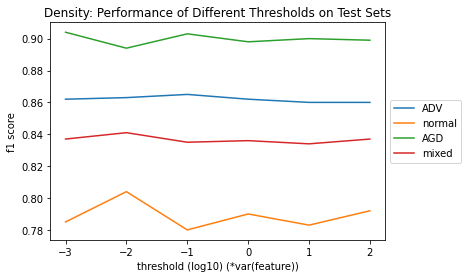

In [144]:
#Run this after running the filtering by density method
plt.plot([math.log(i,10) for i in thresholds], score2, label='ADV')
plt.plot([math.log(i,10) for i in thresholds], score3, label='normal')
plt.plot([math.log(i,10) for i in thresholds], score4, label='AGD')
plt.plot([math.log(i,10) for i in thresholds], score5, label='mixed')
plt.xlabel('threshold (log10) (*var(feature))')
plt.ylabel('f1 score') 
plt.title('Density: Performance of Different Thresholds on Test Sets')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

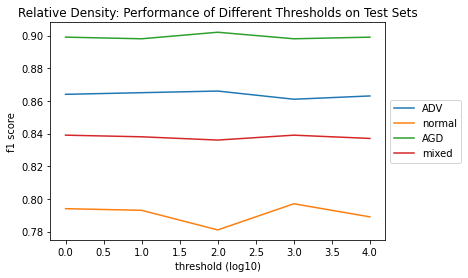

In [140]:
#Run this after running the filtering by relative density method
plt.plot([math.log(i,10) for i in thresholds], score2, label='ADV')
plt.plot([math.log(i,10) for i in thresholds], score3, label='normal')
plt.plot([math.log(i,10) for i in thresholds], score4, label='AGD')
plt.plot([math.log(i,10) for i in thresholds], score5, label='mixed')
plt.xlabel('threshold (log10)')
plt.ylabel('f1 score') 
plt.title('Relative Density: Performance of Different Thresholds on Test Sets')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
#Bagging Ensemble Learning
#MAKE SURE TO UNCOMMENT THE FILTERING METHOD AT THE BOTTOM TO STORE RESULTS BEFORE RUNNING
split=split1=split2= 20000
#thresholds = [0.01]           #for density
thresholds = [10]             #for relative density
score2 = []
score3 = []
score4 = []
score5 = []
X6 = convert(extract(advTest50[0:10000]))               #MaskDGA data - completely ADV
X7 = convert(extract(newtestbenign[0:10000]))           #original data - completely benign
X8 = convert(extract(newtestAGD[0:10000]))              #original data - completely AGD
X9 = convert(extract(advTest50[0:split]+newtestbenign[0:split1]+newtestAGD[0:split2]))
mixedlabels = advTestlabel50[0:split]+newtestbenignlabel[0:split1]+newtestAGDlabel[0:split2]

for i in range(10):
    #sample with replacement
    adv_sample = choices(advTrain, k=split)
    benign_sample = choices(newtrainbenign, k=split1)
    AGD_sample = choices(newtrainAGD, k=split2)
    
    #extract features
    examine_adv = extract(adv_sample)
    examine_benign = extract(benign_sample)
    examine_AGD = extract(AGD_sample)

    #filter anomalies
    adv_output = auto_select(examine_adv, '2', thresholds)
    benign_output = auto_select(examine_benign, '0', thresholds)
    AGD_output = auto_select(examine_AGD, '1', thresholds)

    #convert form
    combined = [0]*7
    combined[0] = adv_output[0][0][0]+benign_output[0][0][0]+AGD_output[0][0][0]
    combined[1] = adv_output[0][0][1]+benign_output[0][0][1]+AGD_output[0][0][1]
    combined[2] = adv_output[0][0][2]+benign_output[0][0][2]+AGD_output[0][0][2]
    combined[3] = adv_output[0][0][3]+benign_output[0][0][3]+AGD_output[0][0][3]
    combined[4] = adv_output[0][0][4]+benign_output[0][0][4]+AGD_output[0][0][4]
    combined[5] = adv_output[0][0][5]+benign_output[0][0][5]+AGD_output[0][0][5]
    combined[6] = adv_output[0][0][6]+benign_output[0][0][6]+AGD_output[0][0][6]
    combined_labels = adv_output[0][1] + benign_output[0][1] + AGD_output[0][1]
    print(len(combined_labels))

    #training each model on a different sample of the same training set
    clf = RandomForestClassifier(max_depth=7, random_state=0)
    clf.fit(convert(combined), combined_labels)
    
    #predict and record f1 scores
    score2.append(round(f1_score(advTestlabel50[0:10000], clf.predict(X6), average='micro'),3))
    score3.append(round(f1_score(newtestbenignlabel[0:10000], clf.predict(X7), average='micro'),3))
    score4.append(round(f1_score(newtestAGDlabel[0:10000], clf.predict(X8), average='micro'),3))
    score5.append(round(f1_score(mixedlabels, clf.predict(X9), average='micro'),3))

#MAKE SURE TO UNCOMMENT THE FILTERING METHOD TO STORE RESULTS BEFORE RUNNING
#bagging_base = [score2,score3,score4,score5]        #no filtering
#bagging_ada1 = [score2,score3,score4,score5]        #IQR
#bagging_ada2 = [score2,score3,score4,score5]        #SD
#bagging_ada3 = [score2,score3,score4,score5]        #density
#bagging_ada4 = [score2,score3,score4,score5]        #relative density

# print(score2)
# print(score3)
# print(score4)
# print(score5)
# print(round(np.mean(score2),3))
# print(round(np.mean(score3),3))
# print(round(np.mean(score4),3))
# print(round(np.mean(score5),3))

60000
60000
60000
60000
60000
60000
60000
60000
60000
60000
[0.498, 0.501, 0.497, 0.496, 0.499, 0.499, 0.499, 0.503, 0.499, 0.509]
[0.892, 0.895, 0.892, 0.89, 0.891, 0.89, 0.893, 0.893, 0.892, 0.902]
[0.771, 0.751, 0.76, 0.764, 0.765, 0.743, 0.749, 0.745, 0.758, 0.736]
[0.888, 0.897, 0.886, 0.898, 0.892, 0.896, 0.9, 0.901, 0.892, 0.902]
[0.84, 0.839, 0.834, 0.84, 0.84, 0.833, 0.837, 0.836, 0.836, 0.836]
0.5
0.893
0.754
0.895
0.837


In [ ]:
#Stacking Ensemble Learning
#MAKE SURE TO UNCOMMENT THE FILTERING METHOD AT THE BOTTOM TO STORE RESULTS BEFORE RUNNING
#get a stacking ensemble of models
level0 = list()
level0.append(('RF', RandomForestClassifier(max_depth=7, random_state=0)))
level0.append(('cart', tree.DecisionTreeClassifier()))
level0.append(('svm', svm.SVC()))
level0.append(('bayes', GaussianNB()))
level1 = LogisticRegression()
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

split=split1=split2= 20000
thresholds = [0.01]           #for density
#thresholds = [10]             #for relative density
score6 = []
score7 = []
score8 = []
score9 = []
X6 = convert(extract(advTest50[0:10000]))               #MaskDGA data - completely ADV
X7 = convert(extract(newtestbenign[0:10000]))           #original data - completely benign
X8 = convert(extract(newtestAGD[0:10000]))              #original data - completely AGD
X9 = convert(extract(advTest50[0:split]+newtestbenign[0:split1]+newtestAGD[0:split2]))
mixedlabels = advTestlabel50[0:split]+newtestbenignlabel[0:split1]+newtestAGDlabel[0:split2]

for i in range(5):
    #sample with replacement
    adv_sample = choices(advTrain, k=split)
    benign_sample = choices(newtrainbenign, k=split1)
    AGD_sample = choices(newtrainAGD, k=split2)
    
    #extract features
    examine_adv = extract(adv_sample)
    examine_benign = extract(benign_sample)
    examine_AGD = extract(AGD_sample)

    #filter anomalies
    adv_output = auto_select(examine_adv, '2', thresholds)
    benign_output = auto_select(examine_benign, '0', thresholds)
    AGD_output = auto_select(examine_AGD, '1', thresholds)

    #convert form
    combined = [0]*7
    combined[0] = adv_output[0][0][0]+benign_output[0][0][0]+AGD_output[0][0][0]
    combined[1] = adv_output[0][0][1]+benign_output[0][0][1]+AGD_output[0][0][1]
    combined[2] = adv_output[0][0][2]+benign_output[0][0][2]+AGD_output[0][0][2]
    combined[3] = adv_output[0][0][3]+benign_output[0][0][3]+AGD_output[0][0][3]
    combined[4] = adv_output[0][0][4]+benign_output[0][0][4]+AGD_output[0][0][4]
    combined[5] = adv_output[0][0][5]+benign_output[0][0][5]+AGD_output[0][0][5]
    combined[6] = adv_output[0][0][6]+benign_output[0][0][6]+AGD_output[0][0][6]
    combined_labels = adv_output[0][1] + benign_output[0][1] + AGD_output[0][1]
    print(len(combined_labels))

    #training each model on a different sample of the same training set
    clf = model
    clf.fit(convert(combined), combined_labels)
    
    #predict and record f1 scores
    score6.append(round(f1_score(advTestlabel50[0:10000], clf.predict(X6), average='micro'),3))
    score7.append(round(f1_score(newtestbenignlabel[0:10000], clf.predict(X7), average='micro'),3))
    score8.append(round(f1_score(newtestAGDlabel[0:10000], clf.predict(X8), average='micro'),3))
    score9.append(round(f1_score(mixedlabels, clf.predict(X9), average='micro'),3))

#MAKE SURE TO UNCOMMENT THE FILTERING METHOD TO STORE RESULTS BEFORE RUNNING
#stacking_base = [score6,score7,score8,score9]        #no filtering
#stacking_ada1 = [score6,score7,score8,score9]        #IQR
#stacking_ada2 = [score6,score7,score8,score9]        #SD
#stacking_ada3 = [score6,score7,score8,score9]        #density
#stacking_ada4 = [score6,score7,score8,score9]        #relative density

# print(score6)
# print(score7)
# print(score8)
# print(score9)
# print(round(np.mean(score6),3))
# print(round(np.mean(score7),3))
# print(round(np.mean(score8),3))
# print(round(np.mean(score9),3))

60000


In [17]:
#compares bagging and stacking for the base results (no filtering)
#computes the means and standard deviation of each set for bagging
#computes the means of each set for stacking
bagging_means = []
bagging_std = []
stacking_means = []

for each in bagging_base:
    bagging_means.append(np.mean(each))
    bagging_std.append(np.std(each))

for each in stacking_base:
    stacking_means.append(np.mean(each))

upper = []
lower = []
for i in range(len(bagging_means)):
    upper.append(bagging_means[i]+1.96*bagging_std[i])
    lower.append(bagging_means[i]-1.96*bagging_std[i])
    
#plots the 95% confidence bands of the bagging resuts and compares with the stacking results
plt.plot(['ADV','normal','AGD','mixed'],bagging_means,'o', label='bagging')
plt.plot(['ADV','ADV','ADV','ADV'],[lower[0],lower[0],bagging_means[0],upper[0]])
plt.plot(['normal','normal','normal','normal'],[lower[1],lower[1],bagging_means[1],upper[1]])
plt.plot(['AGD','AGD','AGD','AGD'],[lower[2],lower[2],bagging_means[2],upper[2]])
plt.plot(['mixed','mixed','mixed','mixed'],[lower[3],lower[3],bagging_means[3],upper[3]])
plt.plot(['ADV','normal','AGD','mixed'],stacking_means,'x', label='stacking')
plt.legend()
plt.title('Base Performances of Ensemble Learning on Four Test Sets')
plt.xlabel('test set')
plt.ylabel('f1 score')
plt.show()

In [218]:
#plot and compare ensembling techniques to anomaly detection methods
final_scores2 = []
final_scores3 = []
final_scores4 = []
final_scores5 = []

final_scores2.append(np.mean(bagging_base[0]))
final_scores2.append(np.mean(bagging_ada1[0]))
final_scores2.append(np.mean(bagging_ada2[0]))
final_scores2.append(np.mean(bagging_ada3[0]))
final_scores2.append(np.mean(bagging_ada4[0]))
final_scores2.append(np.mean(stacking_base[0]))
final_scores2.append(np.mean(stacking_ada1[0]))
final_scores2.append(np.mean(stacking_ada2[0]))
final_scores2.append(np.mean(stacking_ada3[0]))
final_scores2.append(np.mean(stacking_ada4[0]))

final_scores3.append(np.mean(bagging_base[1]))
final_scores3.append(np.mean(bagging_ada1[1]))
final_scores3.append(np.mean(bagging_ada2[1]))
final_scores3.append(np.mean(bagging_ada3[1]))
final_scores3.append(np.mean(bagging_ada4[1]))
final_scores3.append(np.mean(stacking_base[1]))
final_scores3.append(np.mean(stacking_ada1[1]))
final_scores3.append(np.mean(stacking_ada2[1]))
final_scores3.append(np.mean(stacking_ada3[1]))
final_scores3.append(np.mean(stacking_ada4[1]))

final_scores4.append(np.mean(bagging_base[2]))
final_scores4.append(np.mean(bagging_ada1[2]))
final_scores4.append(np.mean(bagging_ada2[2]))
final_scores4.append(np.mean(bagging_ada3[2]))
final_scores4.append(np.mean(bagging_ada4[2]))
final_scores4.append(np.mean(stacking_base[2]))
final_scores4.append(np.mean(stacking_ada1[2]))
final_scores4.append(np.mean(stacking_ada2[2]))
final_scores4.append(np.mean(stacking_ada3[2]))
final_scores4.append(np.mean(stacking_ada4[2]))

final_scores5.append(np.mean(bagging_base[3]))
final_scores5.append(np.mean(bagging_ada1[3]))
final_scores5.append(np.mean(bagging_ada2[3]))
final_scores5.append(np.mean(bagging_ada3[3]))
final_scores5.append(np.mean(bagging_ada4[3]))
final_scores5.append(np.mean(stacking_base[3]))
final_scores5.append(np.mean(stacking_ada1[3]))
final_scores5.append(np.mean(stacking_ada2[3]))
final_scores5.append(np.mean(stacking_ada3[3]))
final_scores5.append(np.mean(stacking_ada4[3]))

ensemble_labels = ['bag none','bag IQR','bag SD','bag dens','bag rel dens',
                   'stack none','stack IQR','stack SD','stack dens','stack rel dens']
plt.figure(figsize =(12, 5))
plt.plot(ensemble_labels,final_scores2,'-o',label='ADV')
plt.plot(ensemble_labels,final_scores3,'-o',label='normal')
plt.plot(ensemble_labels,final_scores4,'-o',label='AGD')
plt.plot(ensemble_labels,final_scores5,'-o',label='mixed')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Performances Post Filtering Anomalies on Four Test Sets')
plt.xlabel('anomaly detection method and ensemble technique')
plt.ylabel('f1 score')
plt.show()